In [1]:
from __future__ import print_function, division

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
import datetime

import tensorflow as tf

from tqdm import tqdm
from glob import glob
import os, sys

%matplotlib inline

##### Some setup data...

In [2]:
team_long_names = [k.strip() for k in """Atlanta Hawks
                    New Jersey Nets
                    Brooklyn Nets
                    Boston Celtics
                    Charlotte Hornets
                    Chicago Bulls
                    Cleveland Cavaliers
                    Dallas Mavericks
                    Denver Nuggets
                    Detroit Pistons
                    Golden State Warriors
                    Houston Rockets
                    Indiana Pacers
                    Los Angeles Clippers
                    Los Angeles Lakers
                    Memphis Grizzlies
                    Miami Heat
                    Milwaukee Bucks
                    Minnesota Timberwolves
                    New Orleans Pelicans
                    New York Knicks
                    Oklahoma City Thunder
                    Orlando Magic
                    Philadelphia 76ers
                    Phoenix Suns
                    Portland Trail Blazers
                    Sacramento Kings
                    San Antonio Spurs
                    Toronto Raptors
                    Utah Jazz
                    Washington Bullets
                    Washington Wizards
                    Seattle SuperSonics
                    Baltimore Bullets""".split('\n')]

team_short_names = [k.strip() for k in """ATL  
                    NJN  
                    BKN  
                    BOS  
                    CHA  
                    CHI  
                    CLE  
                    DAL  
                    DEN  
                    DET  
                    GSW  
                    HOU  
                    IND  
                    LAC  
                    LAL  
                    MEM  
                    MIA  
                    MIL  
                    MIN  
                    NOP  
                    NYK  
                    OKC  
                    ORL  
                    PHI  
                    PHO 
                    POR  
                    SAC  
                    SAS  
                    TOR  
                    UTA  
                    WAS 
                    WAS
                    SEA 
                    BAL""".split()]

long_to_short = dict(zip(team_long_names, team_short_names))
short_to_long = dict(zip(team_short_names, team_long_names))

# first_year = datetime.datetime(1990, 1, 1)
first_year = 1990
years_to_xvals = lambda years: years - first_year

In [3]:
## how do we weight stats when calculating a players value?  larger number = more weight
stat_weights = {'PTS': 2.0, 
                'AST': 1.5,
                'BLK': 1.25,
                'TRB': 1.0,
                'ORB': 0.5, 
                'STL': 1.25,
                'TOV': -2.0,
#                 'MissedShots':-0.5
               }
base_stat_keys = list(stat_weights.keys())

for k in base_stat_keys:
    stat_weights[k + '_PER36'] = stat_weights[k] * 1.25
    
stat_keys = stat_weights.keys()

champ_multiplier = 0.66
ru_multiplier = 0.33
finals_minutes_multiplier = 0.2
playoff_multipliers = lambda ii:  0.1*np.sqrt(int(ii))

mvp_value = 8
dpoy_value = 4
sixth_man_value = 2
finals_mvp_value = 4
all_star_value = 1.5
all_nba_values = {'1st':3, '2nd':2, '3rd':1}

In [150]:
column_renamer = {'Pos':'Position', 
                 'Tm':'Team', 
                 'G':'GamesPlayed', 
                 'GS':'GamesStarted',
                 'MP':'MinutesPlayed',
                 'PF':'Fouls',
                 'Starters':'Player'}

def parse_bball_ref_common_cols(df):
    df.rename(columns=column_renamer, inplace=True)
    df['PlayerName'] = df['Player'].apply(lambda x:  x.split('\\')[0].replace('*', ''))
    df['PlayerID'] = df['Player'].apply(lambda x:  x.split('\\')[1])
    
    df.drop(columns=[k for k in ['Player'] if k in df.keys()], inplace=True)
    return df

def add_additional_stats(df):
    df['MissedShots'] = df['FGA'] - df['FG']
    played = df['MinutesPlayed'] > 0
    
    output = {}
    for key in base_stat_keys:
#         df[key + '_PER36'] = 36.0 * df[key] / df['MinutesPlayed']
        vout = np.zeros(df[key].size)
        vout[played] = 36.0 * df[key].loc[played]/df['MinutesPlayed'].loc[played]
        df[key+'_PER36'] = vout
    return df


def combine_traded_player(rows):
#     out = pd.DataFrame(columns=rows.keys())
    out = dict([(k,None) for k in rows.keys() if not k.endswith('_PER36')])

#     ['Rk', 'Position', 'Age', 'Team', 'GamesPlayed', 'GamesStarted',
#        'MinutesPlayed', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA',
#        '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
#        'BLK', 'TOV', 'Fouls', 'PTS', 'PlayerName', 'PlayerID', 'MissedShots',
#        'Year', 'isFMVP',
#        'isAllNBA_1st', 'isAllNBA_2nd', 'isAllNBA_3rd',
#        'YearlyRegularSeasonValue', 'YearlyAwardsValue', 'YearlyPlayoffsValue',
#        'VeteranStatus', 'isYoungPlayer', 'TotalValue'],
    
    out['Team'] = 'TOT'
    
    ## raw stats -- simply sum these up
    to_sum = ['GamesPlayed', 'GamesStarted', 'MinutesPlayed', 
              'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 
              'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'Fouls', 
              'PTS', 'MissedShots', 'YearlyRegularSeasonValue', 
              'YearlyAwardsValue', 'YearlyPlayoffsValue', 'TotalValue']
    
    for k in to_sum:
        out[k] = rows[k].sum()
    
    to_any = ['isFMVP', 'isAllNBA_1st', 'isAllNBA_2nd', 'isAllNBA_3rd', 'isYoungPlayer']
    for k in to_any:
        out[k] = rows[k].any(axis=None)

    ## Recalculate these
    to_recalc_simple = ['3P%', '2P%', 'FT%']
    for k in to_recalc_simple:
        attempts = k[:-1]+'A'
        makes = k[:-1]
        out[k] = out[makes]*1.0/out[attempts]
        
    ## calculate eFG% by hand
    out['eFG%'] = (out['FG'] + 0.5*out['3P'])/out['FGA']
    
    ## combine all the positions:
    positions = np.unique(rows['Position'].values)
    out['Position'] = ', '.join(positions)
    
    ## Take the best rank of the player...kinda meaningless since I never use it
    out['Rk'] = rows['Rk'].min()
    
    ## these should be the same for the player:
    check_equal = ['Age', 'Year', 'PlayerName', 'PlayerID', 'VeteranStatus']
    
    for k in check_equal:
        vals = rows[k].values
        assert (vals == vals[0]).all(), "assert failed with key = {}:\n{}".format(k, vals)
        out[k] = vals[0]
        
    df = pd.DataFrame(out, index=[0])
    
    ## now add back the PER36
    df = add_additional_stats(df)
    
    assert df.shape[0] == 1
    return df

In [131]:
def find_player_id(player_name):
    possibilities = player_dataset['PlayerName'] == player_name
    if np.count_nonzero(possibilities) == 1:
        return player_dataset['PlayerID'].loc[possibilities].values[0]
    elif np.count_nonzero(possibilities) > 1:
        print("Many options:")
        values = player_dataset['CareerValue'].loc[possibilities]
        pids = []
        for index, row in player_dataset.loc[possibilities].iterrows():
            print('\t{} with a total value of {}'.format(row['PlayerID'], row['CareerValue']))
            pids.append(row['PlayerID'].value)
        print("Returning best career")
        return pids[np.argmax(values)]
    else:
        print("No exact matches... possibilities:")
        from fuzzywuzzy import process
        possibilities = process.extract(player_name, player_dataset['PlayerName'].values, limit=10)
        for poss in possibilities:
            print("\t",poss[0])
        return None

## Read info about teams that made it to the finals, players that are in the HOF, MVP winners, players that made All-NBA and All-Star teams, DPOYs, and Sixth man awards

In [132]:
finals_team_data = pd.read_csv('finals_stats.csv', index_col='Year')
finals_team_data.dropna(axis='index', inplace=True)
finals_team_data['Champion'] = finals_team_data['Champion'].apply(lambda x: long_to_short[x])
finals_team_data['Runner-Up'] = finals_team_data['Runner-Up'].apply(lambda x: long_to_short[x])
finals_team_data.drop(columns=['Lg'], inplace=True)

In [133]:
hof = pd.read_table('hof_players.txt', delim_whitespace=True)
hof['Name'] = [fn + ' ' + ln for (fn, ln) in zip(hof['FirstName'], hof['LastName'])]
hof.drop(columns=['FirstName', 'LastName', 'Height(M)'], inplace=True)
hof_names = np.array(hof['Name'].values)

In [134]:
mvps = parse_bball_ref_common_cols(pd.read_csv('mvp_stats.csv'))
mvps['Year'] = mvps['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
mvps.drop(columns=['Season','Team'], inplace=True)
mvps.set_index('Year', inplace=True)

In [135]:
dpoys = parse_bball_ref_common_cols(pd.read_csv('dpoy.csv'))
dpoys['Year'] = dpoys['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
dpoys.drop(columns=['Season','Team'], inplace=True)
dpoys.set_index('Year', inplace=True)

In [136]:
sixth_man_winners = parse_bball_ref_common_cols(pd.read_csv('sixth_man.csv'))
sixth_man_winners['Year'] = sixth_man_winners['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
sixth_man_winners.set_index('Year', inplace=True)
sixth_man_winners.drop(columns=['Lg', 'Voting', 'Season'], inplace=True)

In [137]:
all_star_pids = {1999:np.array([])}  ### no all-star game in 1999
all_star_files = sorted(glob('all_stars/*.csv'))
for fname in all_star_files:
    year = int(fname.split('/')[-1].split('.')[0])
    adf = parse_bball_ref_common_cols(pd.read_csv(fname))
    ## really don't care about any of the stats in the all-star game
    ## I just want to know if they made it or not
    all_star_pids[year] = adf['PlayerID'].values

In [138]:
all_nba_teams_by_year = {}
all_nba_teams = pd.read_csv('all_nba_teams.csv')
all_nba_teams['Year'] = all_nba_teams['Season'].apply(lambda x: int(x.split('-')[0]) + 1)
all_nba_teams.drop(columns=['Season', 'Lg'], inplace=True)
all_nba_teams.rename(columns={'Tm':'Team'}, inplace=True)
# all_nba_teams.set_index('Year', inplace=True)

all_nba_players_by_year = {}
for year in np.unique(all_nba_teams['Year']):
    teams_this_year = all_nba_teams.loc[all_nba_teams['Year'] == year]
    all_nba_players_by_year[year] = {}
    for idx, row in teams_this_year.iterrows():
        team = row['Team']
        these_players = []
        for val in row[1:-1]:
            if val.endswith(' C'):
                val = val[:-2]
            elif val.endswith(' F'):
                val = val[:-2]
            elif val.endswith(' G'):
                val = val[:-2]
            these_players.append(val)
        assert len(these_players) == 5        
        all_nba_players_by_year[year][team] = these_players

## Read and parse playoff stats for reference later:

In [139]:
def read_and_clean_playoff_year(year):
    dataframes = {}
    for playoff_round in '1234':
        fname = 'playoff_player_stats/{}/round{}.csv'.format(year, playoff_round)
        df = read_and_clean_playoff_round_stats(fname)
        dataframes[playoff_round] = df
        if df.size:
            teams = np.count_nonzero(df['Rk']==1)
            expected_teams = 2**(5-int(playoff_round))
            if teams != expected_teams:
                print("Wrong number of teams for round {} in {}; have {}, expect {}".format(
                    playoff_round, year, teams, expected_teams))
    return dataframes

def read_and_clean_playoff_round_stats(fname):
    if not os.path.isfile(fname):
        print("No file for {}".format(fname))
        return pd.DataFrame(columns=['PlayerID'])
    
    df = pd.read_csv(fname, header=[0, 1])
    new = [''.join(col).strip() for col in df.columns.values]
    for ii, n in enumerate(new):
        if n.startswith('Unnamed'):
            new[ii] = n.split('_')[-1][1:]
        elif n.startswith('Per Game'):
            new[ii] = n.replace(' ','')
        elif n.startswith('Totals'):
            new[ii] = n[len('Totals'):]
        elif n.startswith('Shooting'):
            new[ii] = n[len('Shooting'):]
        else:
            print("don't know how to rename {}".format(n))
    df.columns = new
    
    df = add_additional_stats(parse_bball_ref_common_cols(df))
    return df     

In [140]:
playoff_stats_by_year = {}
playoff_years = range(1990, 2019)
for year in playoff_years:
    playoff_stats_by_year[year] = read_and_clean_playoff_year(year)

# Now read and parse yearly stats

Also calculate player "values" based on both volume and PER stats in the regular season and in the playoffs, with bonuses for contributing to a team that makes the finals, being an all star, or being the MVP or finals MVP.  Also mark who's a young player and a rookie & second year player each year based on their presence in the stats the previous year -- these are going to the players that I look to predict their growth later.

In [141]:
def get_leader_stats(df, msk=None):
    leader_values = {}
    for key in stat_keys:
        if msk is None:
            v = np.nanmax(df[key])
        else:
            v = np.nanmax(df[key].loc[msk])
        if np.isnan(v):
            v = 0
        leader_values[key] = v
    return leader_values

In [142]:
def add_weighted_stat_values(row, leader_stats):
    return sum(stat_weights[key] * row[key] / leader_stats[key] for key in stat_keys)

In [152]:
def read_and_clean_yearly_stats(fname, year, veteran_ids, previous_rookie_ids):
    """
    parse a single year's stats into those i'm looking for
    
    also indicate whether a player is a rookie (0), second year (1), or veteran player (2)
    """
    df = parse_bball_ref_common_cols(pd.read_csv(fname))
    df = add_additional_stats(df)
    df['Year'] = int(year) #datetime.datetime(year, 6, 1)
    
    if year < 2019:
        champ = finals_team_data['Champion'][year]
        runnerup = finals_team_data['Runner-Up'][year]

        champ_players = df['Team'] == champ
        ru_players = df['Team'] == runnerup    
  
        if not champ_players.any():
            print("No players on championship team in {}".format(year))
        if not ru_players.any():
            print("No players on runner-up team in {}".format(year))

        champ_leaders = get_leader_stats(df, msk=champ_players)
        ru_leaders = get_leader_stats(df, msk=ru_players)
        
        dpoy = dpoys['PlayerID'][year]
        sixth_man = sixth_man_winners['PlayerID'][year]
        mvpid = mvps['PlayerID'][year]
        finals_mvp = finals_team_data['Finals MVP'][year]
        all_nba_players = all_nba_players_by_year[year]
    else:
        champ = None
        runnerup = None
        
        mvpid = None
        finals_mvp = None
        dpoy = None
        sixth_man = None
        all_nba_players = {'1st':[], '2nd':[], '3rd':[]}

    all_stars = all_star_pids[year]   
    league_leaders = get_leader_stats(df)

    def calculate_regseason_value(row):          
        if row['Team'] in [champ, runnerup]:
            ## did you play significant minutes on a team that made it to the finals?
            champ_value =  finals_minutes_multiplier * (
                            row['MinutesPlayed']/3000 +  
                            row['GamesStarted']/82 + 
                            0.33 * row['GamesPlayed']/82)
            
            ## did you contribute significantly in terms of pts, rbs, etc?
            if row['Team'] == champ:
                multiplier = champ_multiplier
                leader_values = champ_leaders                
            else:
                multiplier = ru_multiplier
                leader_values = ru_leaders
                
            champ_value += add_weighted_stat_values(row, leader_values)
            champ_value *= multiplier
        else:
            champ_value = 0
                    
        league_value = add_weighted_stat_values(row, league_leaders)
        return champ_value + league_value

    def calculate_playoff_value(row):
        ### no credit if you weren't with the team at the end of the season
        if not row['EndOfSeason']:
            return 0

        playoff_stats_by_round = playoff_stats_by_year[year]
        pid = row['PlayerID']

        total_value = 0
        for playoff_round in range(1, 5):
            # 1 = first round
            # 2 = conference semifinals
            # 3 = east/west finals
            # 4 = nba finals
            playoff_round = str(playoff_round)

            multiplier = playoff_multipliers(playoff_round)
            round_stats = playoff_stats_by_year[year][playoff_round]
            loc = round_stats['PlayerID'] == pid
            
            if np.count_nonzero(loc):
                round_leader_stats = get_leader_stats(round_stats)
                player_round_stats = round_stats.loc[loc]                
                to_add = add_weighted_stat_values(player_round_stats, round_leader_stats).values[0] * multiplier
                
                if np.isnan(to_add):
                    print("Going to add a NaN for pid = {}, year = {}, round = {}".format(pid, year, playoff_round))
                    vals = round_leader_stats.values()
                    if pd.isnull(vals):
                        print('got a NaN in leader stats, year {}, round {}'.format(year, playoff_round))
                        print(round_leader_stats)
                    if pd.isnull(player_round_stats).any(axis=None):
                        print("got a NaN in player stats, pid = {}, year = {}, round = {}".format(pid, year, playoff_round))
                        for colname in stat_keys:
                            print(colname, player_round_stats[colname])
#                             if pd.isnull(player_round_stats[colname]):
#                                 print(colname, player_round_stats[colname])
                    raise TypeError("got a nan")
                total_value += to_add
        return total_value
    
    def calculate_awards_value(row):
        """
        how much do we award a player in terms of all stars, mvps, and finals mvps?
        """
        
        if not row['EndOfSeason']:
            ## only get credit for awards once
            ## (on the team you end the season with)
            return 0
        
        awards_value = 0
        if row['PlayerID'] in all_stars:
            awards_value += all_star_value
            
        for team in ['1st', '2nd', '3rd']:
            if row['isAllNBA_{}'.format(team)]:
                awards_value += all_nba_values[team]
        
        if row['PlayerID'] == mvpid:
            awards_value += mvp_value
            
        if row['PlayerID'] == dpoy:
            awards_value += dpoy_value
            
        if row['PlayerID'] == sixth_man:
            awards_value += sixth_man_value
            
        if row['isFMVP']:
            awards_value += finals_mvp_value
            
        return awards_value
        
    def set_veteran_status(pid):
        if pid in previous_rookie_ids:
            return 1
        elif pid in veteran_ids:
            return 2
        else:
            return 0
    
    def set_isFMVP(row):
        pname = row['PlayerName']
        team = row['Team']
        name = pname.rsplit(maxsplit=1)
        name = name[0][0] + '. ' + name[1]
        if name == finals_mvp and team == champ:
            return True
        else:
            return False
        
    def set_allNBAteam(pname, team):
        if pname in all_nba_players[team]:
            return True
        else:
            return False
    
    
    ## drop the "total" values of players now (not earlier, since we want 
    ## to use total stats to normalize our value added above)
    ## will sum-up player values later, 
    ## but a player gets value from their contribution to each team
    df = df[df['Team'] != 'TOT']
    
    ## then a player only gets credit for the team they're with at the
    ## end of the season, which is the first one to appear in the list
    with_at_eos = np.zeros(df.shape[0])
    msk = np.logical_not(df.duplicated('PlayerID', keep='first'))
    with_at_eos[msk] = True
    df['EndOfSeason'] = with_at_eos
    
    ## set whether a player was the finals mvp:
    df['isFMVP'] = df.apply(set_isFMVP, axis=1)
    num_fmvp = np.count_nonzero(df['isFMVP'].values)
    if num_fmvp != 1:
        print("Wrong number of FMVPs ({}) in year {}".format(num_fmvp, year))
    
    ## set whether a player made each of the all NBA teams:
    for team in ['1st', '2nd', '3rd']:
        dset_name = 'isAllNBA_{}'.format(team)
        df[dset_name] = df['PlayerName'].apply(set_allNBAteam, args=(team,))
        num_on_team = np.count_nonzero(df[dset_name].values)
        if num_on_team != 5:
            print("Wrong number of players ({}) on {} All NBA {} Team".format(num_on_team, year, team))
    ### note -- these datasets will get used later to calculate awards value
    
    df['YearlyRegularSeasonValue'] = df.apply(calculate_regseason_value, axis=1)
    if year < 2019:
        df['YearlyAwardsValue'] = df.apply(calculate_awards_value, axis=1)
        df['YearlyPlayoffsValue'] = df.apply(calculate_playoff_value, axis=1)
    else:
        df['YearlyAwardsValue'] = np.zeros(df.shape[0])
        df['YearlyPlayoffsValue'] = np.zeros(df.shape[0])
        
    df['VeteranStatus'] = df['PlayerID'].apply(set_veteran_status)
    df['isYoungPlayer'] = df['Age'] <= 23
    
    # everyone who was a rookie last year will be a veteran next year
    next_veteran_ids = np.union1d(veteran_ids, previous_rookie_ids)
    rookie_ids = np.array(df['PlayerID'].loc[df['VeteranStatus']==0].values)
    
    df['TotalValue'] = df['YearlyRegularSeasonValue'] + df['YearlyAwardsValue'] + df['YearlyPlayoffsValue']

    ## no longer need to know whether it's the EndOfSeason row
    df.drop(columns=['EndOfSeason'], inplace=True)
    
    ## now handle players that are duplicated (i.e. that were on multiple teams in a given year because of trades)
    ## I'm going to just sum those up basically...
    is_a_duplicate_row = df.duplicated('PlayerID', keep=False)
    
    players_traded = np.unique(df['PlayerID'].loc[is_a_duplicate_row])
    print("Now dealing with {} players that were traded and appear more than once...".format(
        players_traded.size))
    
    df_with_no_dupes = df.drop_duplicates('PlayerID', keep=False, inplace=False)
    ### now add the total values back on to df_with_no_dupes
    to_append = []
    for pid in players_traded:
        rows = df[df['PlayerID']==pid]
        assert rows.shape[0] > 1, "Got a dupilicate PlayerID but only one row..."
        new_row = combine_traded_player(rows)
        to_append.append(new_row)
    df_with_no_dupes = df_with_no_dupes.append(to_append, ignore_index=True, sort=False)

    return df_with_no_dupes, rookie_ids, next_veteran_ids
#     return df, rookie_ids, next_veteran_ids




In [153]:
yearly_files = sorted(glob('yearly_player_stats/*.csv'))

### figure out who's a rookie etc at the beginning of my time....
year_one_df = parse_bball_ref_common_cols(pd.read_csv(yearly_files[0]))
year_two_df = parse_bball_ref_common_cols(pd.read_csv(yearly_files[1]))

year_one_ids = np.unique(year_one_df['PlayerID'].values)
year_two_ids = np.unique(year_two_df['PlayerID'].values)

## if you're in both year 1 and year 2, you're a veteran by year 3
veteran_ids = np.intersect1d(year_one_ids, year_two_ids)

## if you're only in year 2, you're a second year player in year 3
previous_rookie_ids = np.setdiff1d(year_two_ids, year_one_ids)

yearly_files = yearly_files[2:]

In [ ]:
yearly_data = {}
for fname in yearly_files:
    year = int(fname.split('_')[-1].split('.')[0])
    print("Starting {}...".format(year))

    df, previous_rookie_ids, veteran_ids = read_and_clean_yearly_stats(
        fname, year, veteran_ids, previous_rookie_ids)
    
    yearly_data[year] = df
        
all_years = pd.concat(yearly_data.values())

Starting 1990...
Now dealing with 38 players that were traded and appear more than once...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


Starting 1991...
Now dealing with 26 players that were traded and appear more than once...
Starting 1992...
Now dealing with 33 players that were traded and appear more than once...
Starting 1993...
Now dealing with 28 players that were traded and appear more than once...
Starting 1994...
Wrong number of players (6) on 1994 All NBA 3rd Team
Now dealing with 37 players that were traded and appear more than once...
Starting 1995...
Wrong number of players (6) on 1995 All NBA 3rd Team
Now dealing with 22 players that were traded and appear more than once...
Starting 1996...


### A few plots of all the data I just read in

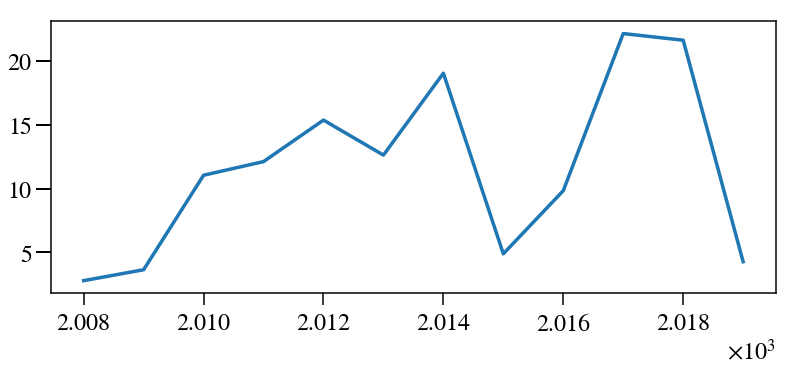

In [23]:
## quick test with Kevin Durant:
fig = plt.figure(figsize=(13, 5))
ax = plt.gca()

loc = all_years['PlayerID'] == 'duranke01'
ax.plot(all_years['Year'].loc[loc], all_years['TotalValue'].loc[loc])

### Plot all the values over all time:

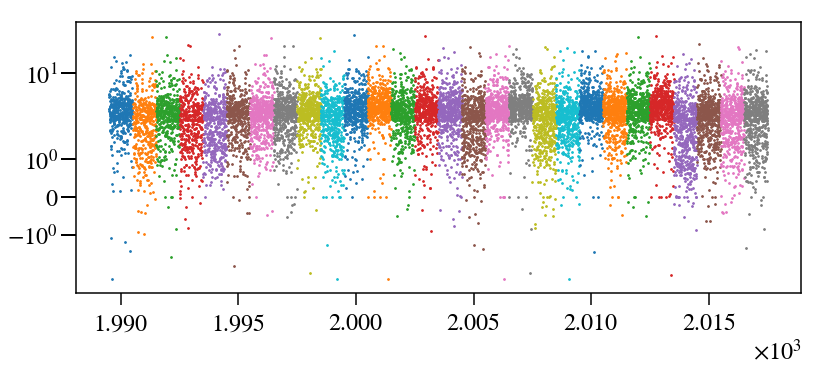

In [24]:
fig = plt.figure(figsize=(13, 5))
ax = plt.gca()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for ii, year in enumerate(range(1990, 2018)):
    df = yearly_data[year]
    nplayers = df.shape[0]
    xvals = year - 0.5 + np.random.rand(nplayers)
    
    c = colors[ii%len(colors)]
    
    ax.scatter(xvals, df['TotalValue'], color=c, s=3)

ax.set_yscale('symlog')

### Now let's also sum up into career stats:

In [52]:
unique_players = np.unique(all_years['PlayerID'].values)
player_dataset = pd.DataFrame()
for pid in tqdm(unique_players):
    rows = all_years.loc[all_years['PlayerID']==pid]
    output_row = {'PlayerID':pid}
    output_row['PlayerName'] = rows['PlayerName'].iloc[0]
    output_row['CareerValue'] = np.sum(rows['TotalValue'].values)
    output_row['CareerRegularSeasonValue'] = np.sum(rows['YearlyRegularSeasonValue'].values)
    output_row['CareerPlayoffValue'] = np.sum(rows['YearlyPlayoffsValue'].values)
    output_row['CareerAwardsValue'] = np.sum(rows['YearlyAwardsValue'].values)
    ryear = rows['Year'].loc[rows['VeteranStatus']==0].values
    if ryear.size == 0:
        ryear = -1
    elif ryear.size == 1:
        ryear = ryear[0]
    else:
        assert (ryear[0] == ryear).all(), "too many rookie years!"
        ryear = ryear[0]
    output_row['RookieYear'] = ryear
    player_dataset = player_dataset.append(output_row, ignore_index=True)

100%|██████████| 2535/2535 [00:12<00:00, 195.72it/s]


In [53]:
player_dataset['RookieYear']

0       1991.0
1       1991.0
2       1998.0
3       1997.0
4       2017.0
5       2006.0
6         -1.0
7       2013.0
8       2007.0
9       2019.0
10      2015.0
11        -1.0
12      2014.0
13      1992.0
14      2018.0
15      2019.0
16      2011.0
17      2008.0
18      2007.0
19        -1.0
20      2008.0
21        -1.0
22      2009.0
23      2013.0
24      2019.0
25      2011.0
26        -1.0
27      2015.0
28      2011.0
29      2007.0
         ...  
2505    1991.0
2506    2008.0
2507    1997.0
2508    1994.0
2509    1995.0
2510    2013.0
2511    1991.0
2512    2018.0
2513    2003.0
2514      -1.0
2515    2015.0
2516    2016.0
2517    1999.0
2518    1990.0
2519    2008.0
2520    2010.0
2521    2008.0
2522    2000.0
2523    2019.0
2524    2009.0
2525    2014.0
2526    2013.0
2527    2013.0
2528    2001.0
2529    1996.0
2530    2006.0
2531    2017.0
2532    2017.0
2533    2018.0
2534    2017.0
Name: RookieYear, Length: 2535, dtype: float64

In [25]:
xticks = range(0, 30, 5)
xticklabels = [str(ii) for ii in range(1990, 2021, 5)]

def plot_player_track_over_all(pid, y='TotalValue'):
    fig = plt.figure(figsize=(13, 5))
    ax = plt.gca()

    loc = all_years['PlayerID']==pid
    name = all_years['PlayerName'].loc[loc].values[0]
    sns.boxplot(data=all_years, x='Year', y=y, ax=ax)

    xvals = years_to_xvals(all_years['Year'].loc[loc])
    ax.plot(xvals, all_years[y].loc[loc], 
            label=name, lw=4, color='k', zorder=99)
    
    leg = ax.legend()
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    print(xticks)
    print(xvals)

range(0, 30, 5)
151    18
167    19
149    20
183    21
137    22
148    23
185    24
175    25
137    26
143    27
171    28
191    29
Name: Year, dtype: int64


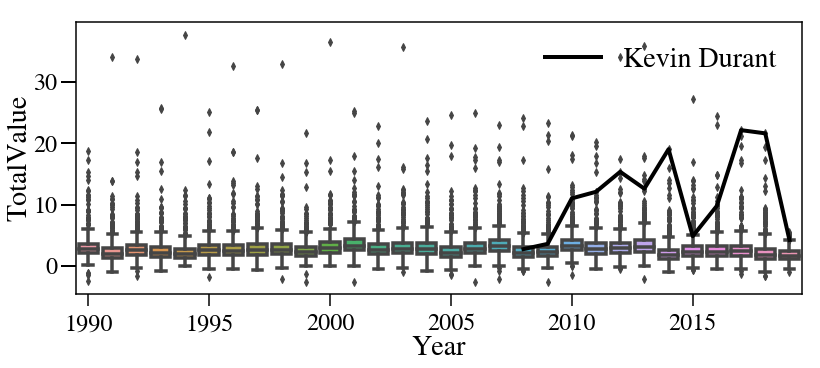

In [26]:
pid = find_player_id('Kevin Durant')
plot_player_track_over_all(pid)

### OK, I'm not sure if this is a great way to value players yet, but let's forge ahead anyway!

What I want to do is:
1. Pick out the stats of first and second year players
    --> Those are my features StatX-FirstYear and StatX-SecondYear
2.  Train to predict their total value over the length of their career.

I need to be extra careful about my test/train sets though, because I want to make sure that I have some (but not all) of the stars in the my dataset.

So I'll need to sort by the total value of a player and then pick ever Nth or something

In [27]:
player_dataset.sort_values('CareerValue', inplace=True, ascending=False)

In [43]:
player_dataset

,CareerAwardsValue,CareerPlayoffValue,CareerRegularSeasonValue,CareerValue,PlayerID,PlayerName,RookieYear
1121,105.0,42.774227,131.688363,279.462591,jamesle01,LeBron James,"256 2004 Name: Year, dtype: int64"
626,88.5,38.634141,144.521978,271.656118,duncati01,Tim Duncan,"137 1998 Name: Year, dtype: int64"
1710,70.0,34.903552,133.470336,238.373889,onealsh01,Shaquille O'Neal,"279 1993 Name: Year, dtype: int64"
322,77.5,29.721317,125.430948,232.652265,bryanko01,Kobe Bryant,"61 1997 Name: Year, dtype: int64"
1225,90.5,29.039946,95.948675,215.488621,jordami01,Michael Jordan,"Series([], Name: Year, dtype: int64)"
782,53.0,17.893826,125.073204,195.967031,garneke01,Kevin Garnett,"155 1996 Name: Year, dtype: int64"
1675,56.5,16.796503,103.481748,176.778251,nowitdi01,Dirk Nowitzki,"327 1999 Name: Year, dtype: int64"
1419,64.0,23.324687,85.929120,173.253806,malonka01,Karl Malone,"Series([], Name: Year, dtype: int64)"
1920,47.0,19.168108,93.757708,159.925815,robinda01,David Robinson,"335 1990 Name: Year, dtype: int64"
1253,30.5,18.544359,108.336047,157.380407,kiddja01,Jason Kidd,"214 1995 Name: Year, dtype: int64"


In [40]:
test_train_ratio = 8

players_to_testtrain = player_dataset.loc[]

train_msk = np.mod(np.arange(players_to_testtrain.index.size),test_train_ratio) != 0

train_dataset = players_to_testtrain[train_msk]
test_dataset = players_to_testtrain[np.logical_not(train_msk)]

train_pids = train_dataset['PlayerID']
test_pids = test_dataset['PlayerID']

print("Training dataset includes {} players; test dataset includes {}".format(
    train_pids.size, test_pids.size))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
def get_features_values(pids, features=stat_keys, value='CareerValue'):
    output_features = {}
    for stat in stat_keys:
        for pid in pids:
            rookie_season = player_dataset['RookieSeason'].loc[]